In [23]:
# importing library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# importing dataset
# dataset= pd.read_csv('Collected_dataset.csv')
# import random
# p = 0.1  # 10% of the lines
# dataset = pd.read_csv(
#          'Collected_dataset.csv',
#          header=0,
#          skiprows=lambda i: i>0 and random.random() > p
# )

In [25]:
# Load the first CSV file into a DataFrame
df1 = pd.read_csv('Collected_Dataset_Training1.csv')

# Load the second CSV file into another DataFrame
df2 = pd.read_csv('Collected_Dataset_Training2.csv')

# Concat the two DataFrames based on common column
df = pd.concat([df1, df2], ignore_index=True)
X = df.iloc[:, 0:-1].values
y = df.iloc[:, -1].values
print(df.shape) 

(1499697, 4)


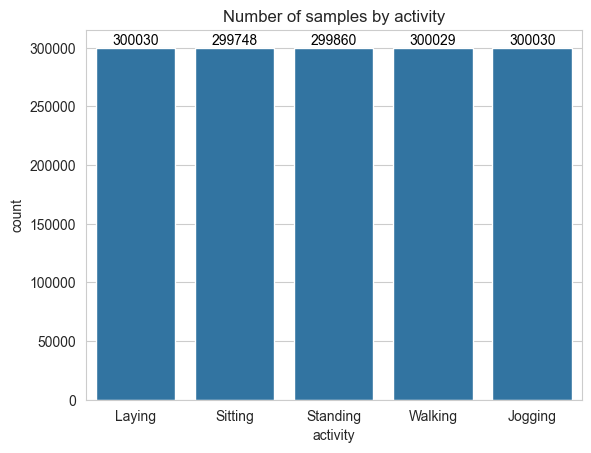

In [26]:
# Plotting dataset Distribution
sns.set_style("whitegrid")
ax = sns.countplot(x='activity', data=df)
for p in ax.patches:
    ax.annotate(f'\n{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', color='black')
plt.title('Number of samples by activity')
plt.show()

In [27]:
# Total Rows in Dataset
print("Total rows in the Dataset: ", df.shape[0])

Total rows in the Dataset:  1499697


In [28]:
# Input Parameter X and its shape
print(X, X.shape)

[[-0.526619 10.041666 -3.643246]
 [-0.641518 10.003366 -3.528347]
 [-0.335121 10.156565 -2.877254]
 ...
 [-3.299702  5.946164 -0.579661]
 [-3.146562  5.883951 -0.024526]
 [-2.743969  6.066403  0.153141]] (1499697, 3)


In [29]:
# Output Parameter y
print(y)

['Laying' 'Laying' 'Laying' ... 'Jogging' 'Jogging' 'Jogging']


In [30]:
# Label Encoding the output y i.e 0-4
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y= le.fit_transform(y)
print(y)

[1 1 1 ... 0 0 0]


In [31]:
# OneHotEncoding the y
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)
print(y, y.shape)

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]] (1499697, 5)


IMPORTING PROCESSED DATA

In [32]:
import pickle
n_time_steps = 50
n_features = 3
step= 10
tensor3d= []
y_adjusted= []

In [33]:
# Processing the X
# for i in range(50, X.shape[0], step):
#   tensor3d_row = []
#   for j in range(n_time_steps):
#     xs = X[:, 0].tolist()[i - j]
#     ys = X[:, 1].tolist()[i - j]
#     zs = X[:, 2].tolist()[i - j]
#     tensor3d_row.append([xs, ys, zs])
#   y_adjusted.append(y[i])
#   tensor3d.append(tensor3d_row)

In [34]:
# Processing the X
for i in range(50, X.shape[0], step):
    tensor3d_row = []
    for j in range(n_time_steps):
        xs = X[i - j, 0]
        ys = X[i - j, 1]
        zs = X[i - j, 2]
        tensor3d_row.append([xs, ys, zs])
    y_adjusted.append(y[i])
    tensor3d.append(tensor3d_row)

In [35]:
# # Saving tensor3D and y_adjusted
# with open("tensor3d.pkl", "wb") as f:
#     pickle.dump(tensor3d, f)

# with open("y_adjusted.pkl", "wb") as f:
#     pickle.dump(y_adjusted, f)

In [36]:
# Loading the saved variable tensor3D and y_adjusted
# with open("tensor3d.pkl", "rb") as f:
#     tensor3d = pickle.load(f)

# with open("y_adjusted.pkl", "rb") as f:
#     y_adjusted = pickle.load(f)

In [37]:
# Converting y_adjusted and tensor3d from Python list to numpy array
tensor3d = np.asarray(tensor3d, dtype= np.float64).reshape(-1, n_time_steps, n_features)
y_adjusted= np.array(y_adjusted)

In [38]:
# Final Shape of the the input and output parameters
print(tensor3d.shape)
print(y_adjusted.shape)

(149965, 50, 3)
(149965, 5)


In [39]:
# Splitting Dataset into training and test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tensor3d, y_adjusted, test_size = 0.2, random_state = 1)
y_train= np.array(y_train)
print(X_train.shape, y_train.shape)

(119972, 50, 3) (119972, 5)


CALLBACKS

In [40]:
# History Callback for loss
from tensorflow.keras.callbacks import History
history = History()

In [41]:
# Callback Function foe applylying metrics
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from keras.callbacks import Callback
class MetricsHistory(Callback):
    def __init__(self, training_data):
        super(MetricsHistory, self).__init__()
        self.training_data = training_data
        self.precision = []
        self.recall = []
        self.f1_score = []
        self.specificity = []

    def on_train_begin(self, logs=None):
        self.precision.clear()
        self.recall.clear()
        self.f1_score.clear()
        self.specificity.clear()

    def on_epoch_end(self, epoch, logs={}):
        x_train, y_train = self.training_data
        y_pred = np.argmax(self.model.predict(x_train), axis=1)
        y_train1D = np.argmax(y_train, axis=1)

        precision = precision_score(y_train1D, y_pred, average='weighted')
        self.precision.append(precision)

        recall = recall_score(y_train1D, y_pred, average='weighted')
        self.recall.append(recall)

        f1 = f1_score(y_train1D, y_pred, average='weighted')
        self.f1_score.append(f1)

        cm = confusion_matrix(y_train1D, y_pred)
        specificityAll= []
        for i in range(5):
            tn = np.sum(cm[np.arange(5) != i, :][:, np.arange(5) != i])
            fp = np.sum(cm[np.arange(5) != i, i])
            specificityEach = round(tn / (tn + fp) , 6)
            specificityAll.append(specificityEach)
        self.specificity.append(specificityAll)
        
        print(f'Epoch {epoch+1}: Precision - {precision:.4f}, Recall - {recall:.4f}, F1 Score - {f1:.4f}, Specificity - {specificityAll}')

metrics_callback_lstm = MetricsHistory(training_data=(X_train, y_train))

LSTM

In [42]:
# Libraries for applying LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [43]:
# Creating and Compiling the LSTM
n_epochs = 50
batch_size = 1024
step= 10
model= Sequential()
model.add(LSTM(128, return_sequences= False, input_shape=(50, 3)))
model.add(Dropout(0.2))
model.add(Dense(units = 128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
# Training the Dataset
model.fit(X_train, y_train, validation_split=0.20, epochs = n_epochs, batch_size = batch_size, callbacks=[metrics_callback_lstm, history])

Epoch 1/50
3750/3750 [==============================] - 33s 9ms/step
Epoch 1: Precision - 0.7746, Recall - 0.7711, F1 Score - 0.7716, Specificity - [0.982684, 0.971971, 0.913751, 0.923026, 0.922391]
94/94 [==============================] - 54s 559ms/step - loss: 0.9495 - accuracy: 0.5869 - val_loss: 0.5879 - val_accuracy: 0.7703
Epoch 2/50
3750/3750 [==============================] - 32s 9ms/step
Epoch 2: Precision - 0.8542, Recall - 0.8505, F1 Score - 0.8517, Specificity - [0.993415, 0.976979, 0.924921, 0.95031, 0.967533]
94/94 [==============================] - 49s 526ms/step - loss: 0.5620 - accuracy: 0.7816 - val_loss: 0.4325 - val_accuracy: 0.8501
Epoch 3/50
3750/3750 [==============================] - 32s 9ms/step
Epoch 3: Precision - 0.8539, Recall - 0.8436, F1 Score - 0.8456, Specificity - [0.996458, 0.985652, 0.917228, 0.933031, 0.972145]
94/94 [==============================] - 49s 526ms/step - loss: 0.4505 - accuracy: 0.8356 - val_loss: 0.4088 - val_accuracy: 0.8425
Epoch 4/

LSTM TEST DATA EVALUATION

In [45]:
#  Test Data accuracy and loss
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy using LSTM :", accuracy)
print("Test Loss using LSTM:", loss)

 1/30 [>.............................] - ETA: 3s - loss: 0.1394 - accuracy: 0.9463

30/30 [==============================] - 2s 72ms/step - loss: 0.1468 - accuracy: 0.9479
Test Accuracy using LSTM : 0.9479211568832397
Test Loss using LSTM: 0.1468440592288971


In [46]:
# Test Data precision
y_pred = model.predict(X_test,  batch_size = batch_size, verbose = 1)
y_pred= np.argmax(y_pred, axis=1)
y_test1D= np.argmax(y_test, axis=1)
print(y_test1D, y_pred)
precision= precision_score(y_test1D, y_pred, average='weighted')
print("Precision:" ,precision)

30/30 [==============================] - 2s 69ms/step
[3 2 0 ... 3 0 3] [3 2 0 ... 3 0 3]
Precision: 0.9482128066000886


In [47]:
# Recall
recall = recall_score(y_test1D, y_pred, average='weighted')
print("Recall: ",recall)

Recall:  0.9479211816090422


In [48]:
# F1 Score
f1 = f1_score(y_test1D, y_pred, average='weighted')
print("F1 Score:", f1)

F1 Score: 0.9479437097996948


In [49]:
# Specificity
cm = confusion_matrix(y_test1D, y_pred)

# Calculate specificity for each class
specificities = []
for i in range(5):  # Assuming 5 classes
    tn = np.sum(cm[np.arange(5) != i, :][:, np.arange(5) != i])  # Sum of true negatives (exclude class i)
    fp = np.sum(cm[np.arange(5) != i, i])  # Sum of false positives (class i mistakenly predicted as others)
    specificity = round(tn / (tn + fp), 4)
    specificities.append(specificity)

print("Specificity for each class:", specificities)

Specificity for each class: [0.9976, 0.9899, 0.9769, 0.9779, 0.9926]


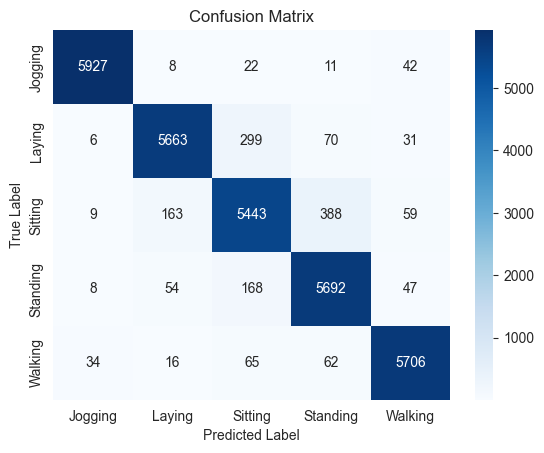

In [50]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test1D, y_pred)

class_names = ['Jogging', 'Laying', 'Sitting', 'Standing', 'Walking']

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

TRAINING PHASE METRICS GRAPHS: LSTM

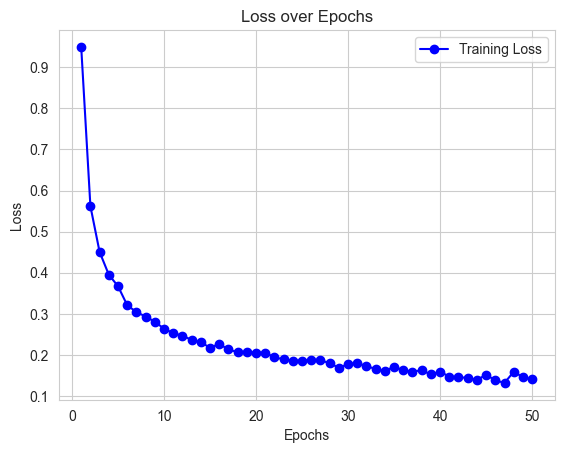

In [51]:
# Loss Per Epoch
train_loss = history.history['loss']
plt.plot(range(1, len(train_loss) + 1), train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

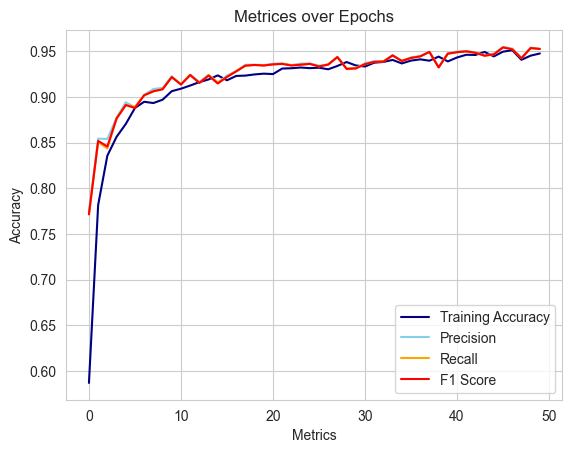

In [52]:
# Accuracy, Precision, F1 Score, Recall Graph
colors = ['navy', 'skyblue', 'orange', 'red']
train_accuracy = history.history['accuracy']
plt.plot(train_accuracy, color=colors[0], label='Training Accuracy')
plt.plot(metrics_callback_lstm.precision, color=colors[1], label='Precision')
plt.plot(metrics_callback_lstm.recall, color=colors[2], label='Recall')
plt.plot(metrics_callback_lstm.f1_score, color=colors[3], label='F1 Score')
plt.title('Metrices over Epochs')
plt.xlabel('Metrics')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
# # Precision Plot
# plt.plot(metrics_callback_lstm.precision, label='Precision')
# plt.xlabel('Epochs')
# plt.ylabel('Precision')
# plt.title('Precision vs Epochs')
# plt.legend()
# plt.show()

In [54]:
# # Recall Plot
# plt.plot(metrics_callback_lstm.recall, label='Recall')
# plt.xlabel('Epochs')
# plt.ylabel('Recall')
# plt.title('Recall vs Epochs')
# plt.legend()
# plt.show()

In [55]:
# # F1 Score Plot
# plt.plot(metrics_callback_lstm.f1_score, label='F1 Score')
# plt.xlabel('Epochs')
# plt.ylabel('F1 Score')
# plt.title('F1 Score vs Epochs')
# plt.legend()
# plt.show()

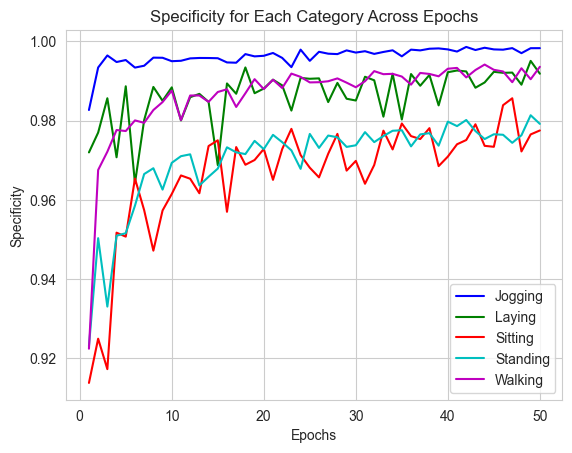

In [56]:
# Specificity Plot
colors = ['b', 'g', 'r', 'c', 'm']
activity_names = ['Jogging', 'Laying', 'Sitting', 'Standing', 'Walking']
specificity_data= np.array(metrics_callback_lstm.specificity)

for i in range(specificity_data.shape[1]):
    plt.plot(range(1, specificity_data.shape[0] + 1), specificity_data[:, i], label=activity_names[i], color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.title('Specificity for Each Category Across Epochs')
plt.legend()
plt.grid(True)
plt.show()

RNN

In [57]:
# RNN model creation and compilation
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout,SimpleRNN
rnn_model= Sequential()
rnn_model.add(SimpleRNN(64, return_sequences= False, input_shape=(50, 3)))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(units = 128, activation='relu'))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(5, activation = 'softmax'))
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
# Callback objects
metrics_callback_rnn = MetricsHistory(training_data=(X_train, y_train))
history_rnn = History()

In [59]:
# Model training
rnn_model.fit(X_train, y_train, validation_split=0.20, epochs = n_epochs, batch_size = batch_size, callbacks=[metrics_callback_rnn, history_rnn])

Epoch 1/50
3750/3750 [==============================] - 7s 2ms/step
Epoch 1: Precision - 0.5951, Recall - 0.5871, F1 Score - 0.5699, Specificity - [0.974369, 0.898014, 0.935946, 0.789505, 0.885991]
94/94 [==============================] - 11s 110ms/step - loss: 1.3549 - accuracy: 0.3899 - val_loss: 0.9968 - val_accuracy: 0.5846
Epoch 2/50
3750/3750 [==============================] - 7s 2ms/step
Epoch 2: Precision - 0.6915, Recall - 0.6837, F1 Score - 0.6786, Specificity - [0.970598, 0.9214, 0.900925, 0.858934, 0.952813]
94/94 [==============================] - 10s 109ms/step - loss: 0.9427 - accuracy: 0.5894 - val_loss: 0.7424 - val_accuracy: 0.6830
Epoch 3/50
3750/3750 [==============================] - 7s 2ms/step
Epoch 3: Precision - 0.7445, Recall - 0.7396, F1 Score - 0.7357, Specificity - [0.969504, 0.933301, 0.932562, 0.885874, 0.953251]
94/94 [==============================] - 10s 108ms/step - loss: 0.7637 - accuracy: 0.6744 - val_loss: 0.6379 - val_accuracy: 0.7385
Epoch 4/50
3

RNN TEST DATA EVALUATION

30/30 [==============================] - 0s 10ms/step - loss: 0.4285 - accuracy: 0.8400
Test Accuracy using RNN : 0.8399959802627563
Test Loss using RNN: 0.4285198152065277
30/30 [==============================] - 0s 10ms/step
[3 2 0 ... 3 0 3] [3 3 4 ... 3 3 3]
Precision: 0.8437079381159432
Recall:  0.8399959990664488
F1 Score: 0.8406566492746559
Specificity for each class: [0.9809, 0.9779, 0.938, 0.9505, 0.9527]


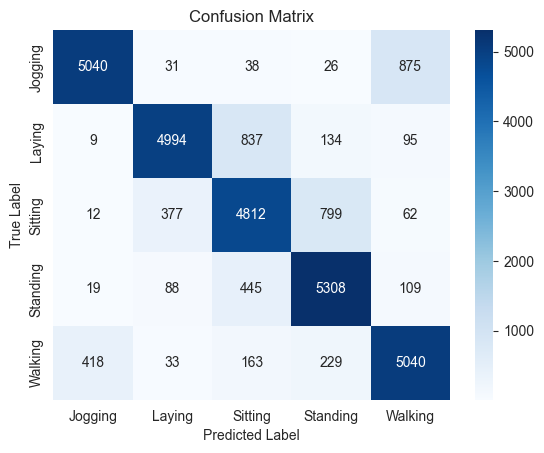

In [60]:
loss, accuracy = rnn_model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy using RNN :", accuracy)
print("Test Loss using RNN:", loss)
# Test Data precision
y_pred = rnn_model.predict(X_test,  batch_size = batch_size, verbose = 1)
y_pred= np.argmax(y_pred, axis=1)
y_test1D= np.argmax(y_test, axis=1)
print(y_test1D, y_pred)
precision= precision_score(y_test1D, y_pred, average='weighted')
print("Precision:" ,precision)
# Recall
recall = recall_score(y_test1D, y_pred, average='weighted')
print("Recall: ",recall)
# F1 Score
f1 = f1_score(y_test1D, y_pred, average='weighted')
print("F1 Score:", f1)
# Specificity
cm = confusion_matrix(y_test1D, y_pred)

# Calculate specificity for each class
specificities = []
for i in range(5):  # Assuming 5 classes
    tn = np.sum(cm[np.arange(5) != i, :][:, np.arange(5) != i])  # Sum of true negatives (exclude class i)
    fp = np.sum(cm[np.arange(5) != i, i])  # Sum of false positives (class i mistakenly predicted as others)
    specificity = round(tn / (tn + fp), 4)
    specificities.append(specificity)

print("Specificity for each class:", specificities)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test1D, y_pred)

class_names = ['Jogging', 'Laying', 'Sitting', 'Standing', 'Walking']

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

TRAINING PHASE METRICS GRAPHS: RNN

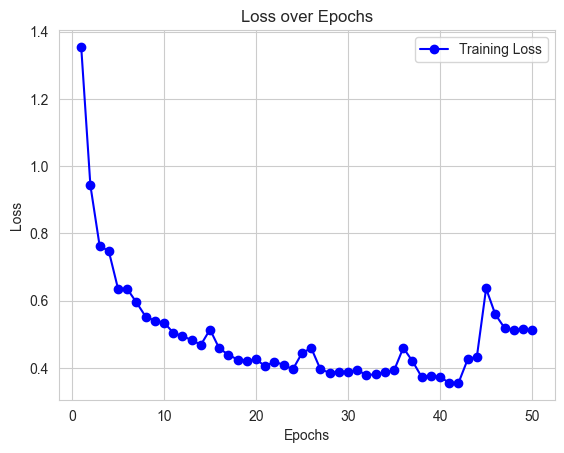

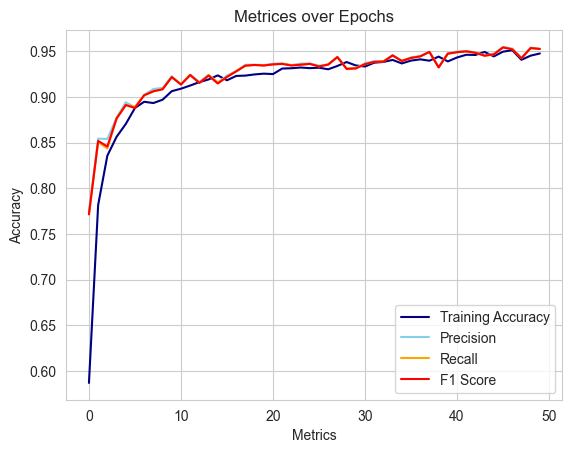

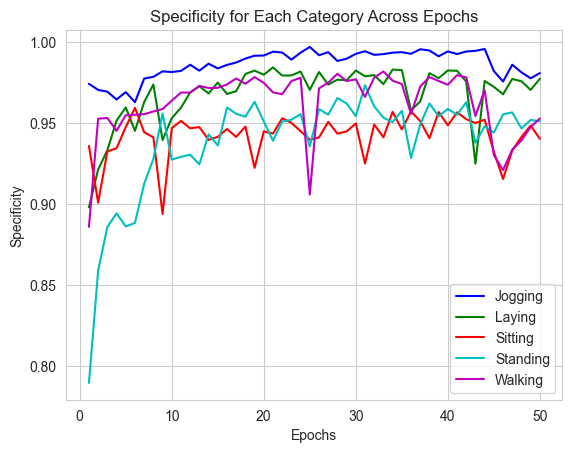

In [61]:
# Loss Per Epoch
train_loss = history_rnn.history['loss']
plt.plot(range(1, len(train_loss) + 1), train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy, Precision, F1 Score, Recall Graph
colors = ['navy', 'skyblue', 'orange', 'red']
train_accuracy = history.history['accuracy']
plt.plot(train_accuracy, color=colors[0], label='Training Accuracy')
plt.plot(metrics_callback_lstm.precision, color=colors[1], label='Precision')
plt.plot(metrics_callback_lstm.recall, color=colors[2], label='Recall')
plt.plot(metrics_callback_lstm.f1_score, color=colors[3], label='F1 Score')
plt.title('Metrices over Epochs')
plt.xlabel('Metrics')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Specificity Plot
colors = ['b', 'g', 'r', 'c', 'm']
activity_names = ['Jogging', 'Laying', 'Sitting', 'Standing', 'Walking']
specificity_data= np.array(metrics_callback_rnn.specificity)

for i in range(specificity_data.shape[1]):
    plt.plot(range(1, specificity_data.shape[0] + 1), specificity_data[:, i], label=activity_names[i], color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.title('Specificity for Each Category Across Epochs')
plt.legend()
plt.grid(True)
plt.show()

GRU

In [62]:
# GRU Model creation and compilation
from keras.layers import GRU
gruModel = Sequential()
gruModel.add(GRU(units = 64, input_shape = (X_train.shape[1], X_train.shape[2])))
gruModel.add(Dropout(0.2))
gruModel.add(Dense(units = 128, activation='relu' ))
gruModel.add(Dropout(0.2))
gruModel.add(Dense(y_train.shape[1], activation = 'softmax'))

gruModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
# Creating Callback Objects
metrics_callback_GRU = MetricsHistory(training_data=(X_train, y_train))
history_GRU = History()

In [64]:
# Model Training
gruModel.fit(X_train, y_train, validation_split=0.20, epochs = n_epochs, batch_size = batch_size, callbacks=[metrics_callback_GRU, history_GRU])

Epoch 1/50
3750/3750 [==============================] - 14s 4ms/step
Epoch 1: Precision - 0.5500, Recall - 0.5582, F1 Score - 0.5466, Specificity - [0.968722, 0.874962, 0.911429, 0.843885, 0.848642]
94/94 [==============================] - 23s 234ms/step - loss: 1.3474 - accuracy: 0.3867 - val_loss: 0.9807 - val_accuracy: 0.5562
Epoch 2/50
3750/3750 [==============================] - 13s 4ms/step
Epoch 2: Precision - 0.7504, Recall - 0.7549, F1 Score - 0.7438, Specificity - [0.979058, 0.920327, 0.943493, 0.890063, 0.960762]
94/94 [==============================] - 21s 228ms/step - loss: 0.8046 - accuracy: 0.6415 - val_loss: 0.5953 - val_accuracy: 0.7553
Epoch 3/50
3750/3750 [==============================] - 14s 4ms/step
Epoch 3: Precision - 0.8034, Recall - 0.8030, F1 Score - 0.7953, Specificity - [0.990008, 0.908083, 0.952675, 0.929436, 0.973563]
94/94 [==============================] - 21s 229ms/step - loss: 0.6161 - accuracy: 0.7447 - val_loss: 0.5116 - val_accuracy: 0.8039
Epoch 4

GRU TEST DATA EVALUATION

 1/30 [>.............................] - ETA: 1s - loss: 0.1964 - accuracy: 0.9316

30/30 [==============================] - 1s 29ms/step - loss: 0.2216 - accuracy: 0.9281
Test Accuracy using RNN : 0.9281165599822998
Test Loss using RNN: 0.2215675562620163
30/30 [==============================] - 1s 29ms/step
[3 2 0 ... 3 0 3] [3 2 0 ... 3 0 3]
Precision: 0.9293990121749098
Recall:  0.9281165605307905
F1 Score: 0.928131812191126
Specificity for each class: [0.995, 0.9934, 0.9681, 0.9679, 0.9858]


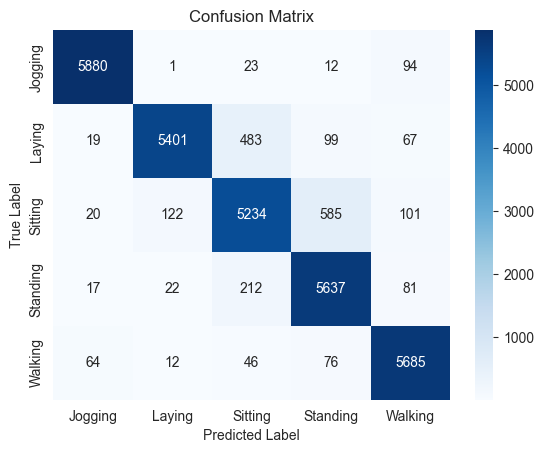

In [65]:
loss, accuracy = gruModel.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy using RNN :", accuracy)
print("Test Loss using RNN:", loss)
# Test Data precision
y_pred = gruModel.predict(X_test,  batch_size = batch_size, verbose = 1)
y_pred= np.argmax(y_pred, axis=1)
y_test1D= np.argmax(y_test, axis=1)
print(y_test1D, y_pred)
precision= precision_score(y_test1D, y_pred, average='weighted')
print("Precision:" ,precision)
# Recall
recall = recall_score(y_test1D, y_pred, average='weighted')
print("Recall: ",recall)
# F1 Score
f1 = f1_score(y_test1D, y_pred, average='weighted')
print("F1 Score:", f1)
# Specificity
cm = confusion_matrix(y_test1D, y_pred)

# Calculate specificity for each class
specificities = []
for i in range(5):  # Assuming 5 classes
    tn = np.sum(cm[np.arange(5) != i, :][:, np.arange(5) != i])  # Sum of true negatives (exclude class i)
    fp = np.sum(cm[np.arange(5) != i, i])  # Sum of false positives (class i mistakenly predicted as others)
    specificity = round(tn / (tn + fp), 4)
    specificities.append(specificity)

print("Specificity for each class:", specificities)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test1D, y_pred)

class_names = ['Jogging', 'Laying', 'Sitting', 'Standing', 'Walking']

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

TRAINING PHASE METRICS GRAPHS: GRU

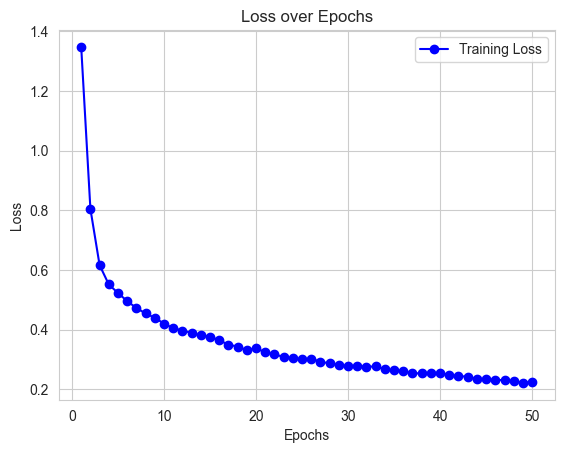

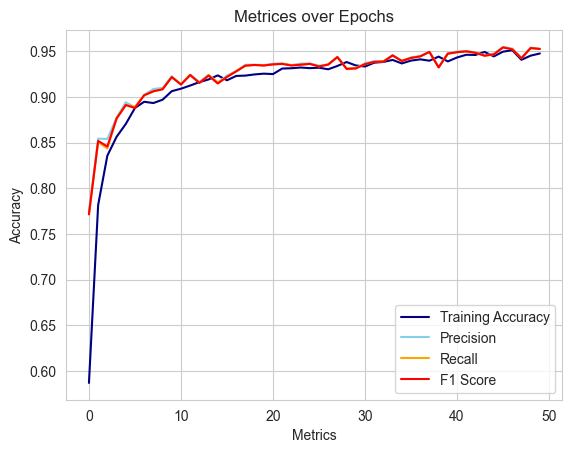

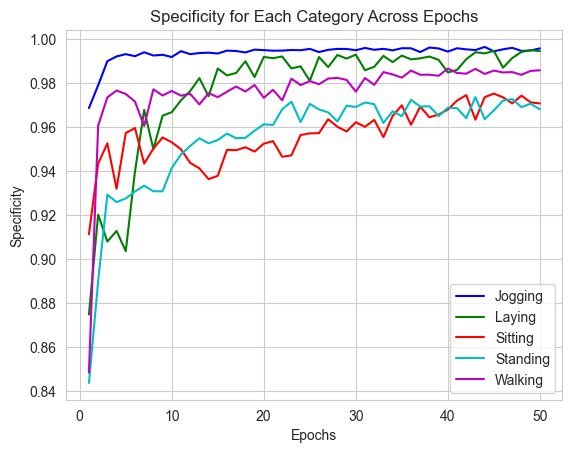

In [66]:
# Loss Per Epoch
train_loss = history_GRU.history['loss']
plt.plot(range(1, len(train_loss) + 1), train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy, Precision, F1 Score, Recall Graph
colors = ['navy', 'skyblue', 'orange', 'red']
train_accuracy = history.history['accuracy']
plt.plot(train_accuracy, color=colors[0], label='Training Accuracy')
plt.plot(metrics_callback_lstm.precision, color=colors[1], label='Precision')
plt.plot(metrics_callback_lstm.recall, color=colors[2], label='Recall')
plt.plot(metrics_callback_lstm.f1_score, color=colors[3], label='F1 Score')
plt.title('Metrices over Epochs')
plt.xlabel('Metrics')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Specificity Plot
colors = ['b', 'g', 'r', 'c', 'm']
activity_names = ['Jogging', 'Laying', 'Sitting', 'Standing', 'Walking']
specificity_data= np.array(metrics_callback_GRU.specificity)

for i in range(specificity_data.shape[1]):
    plt.plot(range(1, specificity_data.shape[0] + 1), specificity_data[:, i], label=activity_names[i], color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.title('Specificity for Each Category Across Epochs')
plt.legend()
plt.grid(True)
plt.show()

BI-RNN

In [67]:
# Model Creation and Compilation
from keras.layers import Bidirectional

biRNNModel = Sequential()
biRNNModel.add(Bidirectional(SimpleRNN(units=64), input_shape=(X_train.shape[1], X_train.shape[2])))
biRNNModel.add(Dropout(0.2))
biRNNModel.add(Dense(units=128, activation='relu'))
biRNNModel.add(Dropout(0.2))
biRNNModel.add(Dense(y_train.shape[1], activation='softmax'))

biRNNModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [68]:
# CallBack Objects
metrics_callback_BiRnn = MetricsHistory(training_data=(X_train, y_train))
history_BiRnn = History()

In [69]:
# Model Training
biRNNModel.fit(X_train, y_train, validation_split=0.20, epochs = n_epochs, batch_size = batch_size, callbacks=[metrics_callback_BiRnn, history_BiRnn])

Epoch 1/50
3750/3750 [==============================] - 9s 2ms/step
Epoch 1: Precision - 0.6519, Recall - 0.6316, F1 Score - 0.6285, Specificity - [0.97612, 0.938913, 0.910451, 0.807264, 0.906752]
94/94 [==============================] - 15s 148ms/step - loss: 1.2502 - accuracy: 0.4562 - val_loss: 0.8988 - val_accuracy: 0.6260
Epoch 2/50
3750/3750 [==============================] - 10s 3ms/step
Epoch 2: Precision - 0.7366, Recall - 0.7283, F1 Score - 0.7286, Specificity - [0.964919, 0.962975, 0.90662, 0.883904, 0.941963]
94/94 [==============================] - 15s 157ms/step - loss: 0.8571 - accuracy: 0.6428 - val_loss: 0.6670 - val_accuracy: 0.7249
Epoch 3/50
3750/3750 [==============================] - 9s 2ms/step
Epoch 3: Precision - 0.8138, Recall - 0.8067, F1 Score - 0.8079, Specificity - [0.977516, 0.979592, 0.919539, 0.924371, 0.957351]
94/94 [==============================] - 13s 140ms/step - loss: 0.6768 - accuracy: 0.7312 - val_loss: 0.5118 - val_accuracy: 0.8077
Epoch 4/50


BI-RNN TEST DATA EVALUATION

30/30 [==============================] - 0s 12ms/step - loss: 0.3044 - accuracy: 0.8928
Test Accuracy using BI-RNN : 0.892841637134552
Test Loss using BI-RNN: 0.30438217520713806
30/30 [==============================] - 0s 11ms/step
[3 2 0 ... 3 0 3] [3 2 4 ... 3 0 3]
Precision: 0.8950631029822657
Recall:  0.8928416630547128
F1 Score: 0.8926505392406412
Specificity for each class: [0.9897, 0.9869, 0.9558, 0.9633, 0.9704]


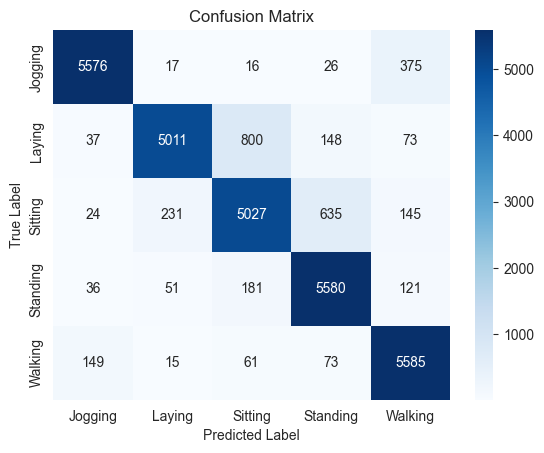

In [70]:
loss, accuracy = biRNNModel.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy using BI-RNN :", accuracy)
print("Test Loss using BI-RNN:", loss)
# Test Data precision
y_pred = biRNNModel.predict(X_test,  batch_size = batch_size, verbose = 1)
y_pred= np.argmax(y_pred, axis=1)
y_test1D= np.argmax(y_test, axis=1)
print(y_test1D, y_pred)
precision= precision_score(y_test1D, y_pred, average='weighted')
print("Precision:" ,precision)
# Recall
recall = recall_score(y_test1D, y_pred, average='weighted')
print("Recall: ",recall)
# F1 Score
f1 = f1_score(y_test1D, y_pred, average='weighted')
print("F1 Score:", f1)
# Specificity
cm = confusion_matrix(y_test1D, y_pred)

# Calculate specificity for each class
specificities = []
for i in range(5):  # Assuming 5 classes
    tn = np.sum(cm[np.arange(5) != i, :][:, np.arange(5) != i])  # Sum of true negatives (exclude class i)
    fp = np.sum(cm[np.arange(5) != i, i])  # Sum of false positives (class i mistakenly predicted as others)
    specificity = round(tn / (tn + fp), 4)
    specificities.append(specificity)

print("Specificity for each class:", specificities)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test1D, y_pred)

class_names = ['Jogging', 'Laying', 'Sitting', 'Standing', 'Walking']

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

TRAINING PHASE METRICS GRAPHS: BI-RNN

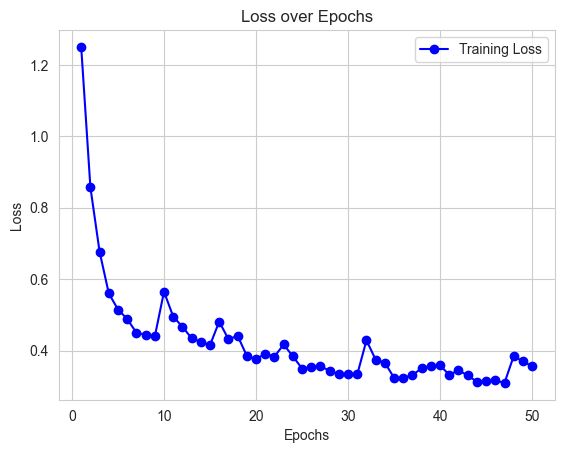

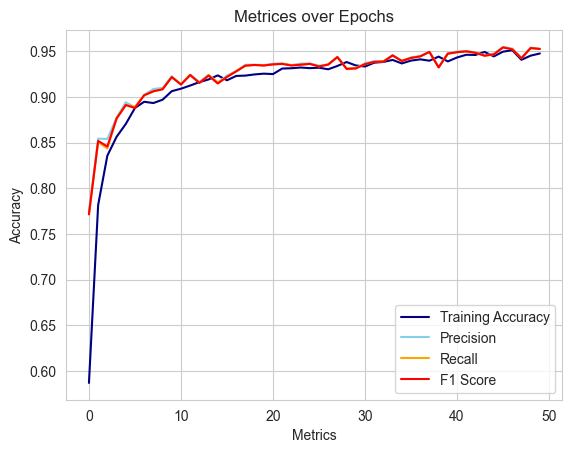

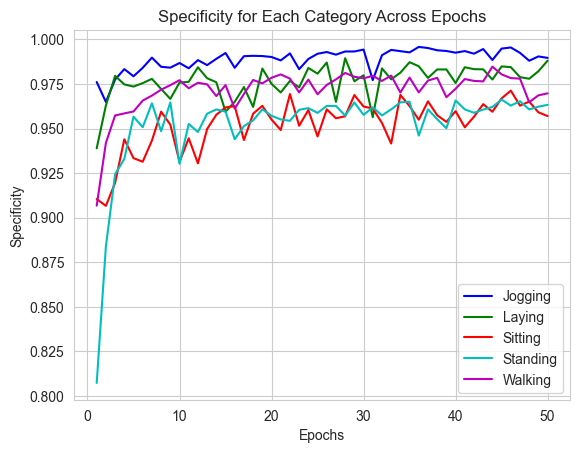

In [71]:
# Loss Per Epoch
train_loss = history_BiRnn.history['loss']
plt.plot(range(1, len(train_loss) + 1), train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy, Precision, F1 Score, Recall Graph
colors = ['navy', 'skyblue', 'orange', 'red']
train_accuracy = history.history['accuracy']
plt.plot(train_accuracy, color=colors[0], label='Training Accuracy')
plt.plot(metrics_callback_lstm.precision, color=colors[1], label='Precision')
plt.plot(metrics_callback_lstm.recall, color=colors[2], label='Recall')
plt.plot(metrics_callback_lstm.f1_score, color=colors[3], label='F1 Score')
plt.title('Metrices over Epochs')
plt.xlabel('Metrics')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Specificity Plot
colors = ['b', 'g', 'r', 'c', 'm']
activity_names = ['Jogging', 'Laying', 'Sitting', 'Standing', 'Walking']
specificity_data= np.array(metrics_callback_BiRnn.specificity)

for i in range(specificity_data.shape[1]):
    plt.plot(range(1, specificity_data.shape[0] + 1), specificity_data[:, i], label=activity_names[i], color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.title('Specificity for Each Category Across Epochs')
plt.legend()
plt.grid(True)
plt.show()

BI-LSTM

In [72]:
# Model creation and Compilation
from keras.layers import Bidirectional
biLSTMModel = Sequential()
biLSTMModel.add(Bidirectional(LSTM(units = 64), input_shape = (X_train.shape[1], X_train.shape[2])))
biLSTMModel.add(Dropout(0.2))
biLSTMModel.add(Dense(units = 128, activation='relu' ))
biLSTMModel.add(Dropout(0.2))
biLSTMModel.add(Dense(y_train.shape[1], activation = 'softmax'))

biLSTMModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [73]:
# Callback Object
metrics_callback_BiLstm = MetricsHistory(training_data=(X_train, y_train))
history_BiLstm = History()

In [74]:
# Model Training
biLSTMModel.fit(X_train, y_train, validation_split=0.20, epochs = n_epochs, batch_size = batch_size, callbacks=[metrics_callback_BiLstm, history_BiLstm])

Epoch 1/50
3750/3750 [==============================] - 18s 5ms/step
Epoch 1: Precision - 0.7949, Recall - 0.7830, F1 Score - 0.7850, Specificity - [0.99304, 0.973356, 0.898021, 0.905028, 0.959375]
94/94 [==============================] - 32s 321ms/step - loss: 1.0171 - accuracy: 0.5659 - val_loss: 0.5740 - val_accuracy: 0.7837
Epoch 2/50
3750/3750 [==============================] - 16s 4ms/step
Epoch 2: Precision - 0.8598, Recall - 0.8579, F1 Score - 0.8583, Specificity - [0.991654, 0.975032, 0.933437, 0.956177, 0.966052]
94/94 [==============================] - 28s 300ms/step - loss: 0.5353 - accuracy: 0.7978 - val_loss: 0.4182 - val_accuracy: 0.8556
Epoch 3/50
3750/3750 [==============================] - 18s 5ms/step
Epoch 3: Precision - 0.8736, Recall - 0.8684, F1 Score - 0.8697, Specificity - [0.995489, 0.984101, 0.930199, 0.951217, 0.974481]
94/94 [==============================] - 30s 320ms/step - loss: 0.4408 - accuracy: 0.8393 - val_loss: 0.3749 - val_accuracy: 0.8679
Epoch 4/

BI-LSTM TEST DATA EVALUATION

30/30 [==============================] - 2s 53ms/step - loss: 0.1650 - accuracy: 0.9406
Test Accuracy using RNN : 0.9406194686889648
Test Loss using RNN: 0.16504445672035217
30/30 [==============================] - 2s 53ms/step
[3 2 0 ... 3 0 3] [3 2 0 ... 3 0 3]
Precision: 0.94071391488848
Recall:  0.9406194778781716
F1 Score: 0.9403787099031147
Specificity for each class: [0.9961, 0.9843, 0.9804, 0.975, 0.99]


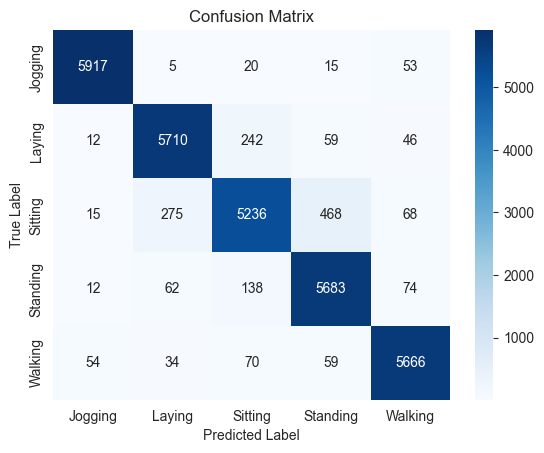

In [75]:
loss, accuracy = biLSTMModel.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy using RNN :", accuracy)
print("Test Loss using RNN:", loss)
# Test Data precision
y_pred = biLSTMModel.predict(X_test,  batch_size = batch_size, verbose = 1)
y_pred= np.argmax(y_pred, axis=1)
y_test1D= np.argmax(y_test, axis=1)
print(y_test1D, y_pred)
precision= precision_score(y_test1D, y_pred, average='weighted')
print("Precision:" ,precision)
# Recall
recall = recall_score(y_test1D, y_pred, average='weighted')
print("Recall: ",recall)
# F1 Score
f1 = f1_score(y_test1D, y_pred, average='weighted')
print("F1 Score:", f1)
# Specificity
cm = confusion_matrix(y_test1D, y_pred)

# Calculate specificity for each class
specificities = []
for i in range(5):  # Assuming 5 classes
    tn = np.sum(cm[np.arange(5) != i, :][:, np.arange(5) != i])  # Sum of true negatives (exclude class i)
    fp = np.sum(cm[np.arange(5) != i, i])  # Sum of false positives (class i mistakenly predicted as others)
    specificity = round(tn / (tn + fp), 4)
    specificities.append(specificity)

print("Specificity for each class:", specificities)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test1D, y_pred)

class_names = ['Jogging', 'Laying', 'Sitting', 'Standing', 'Walking']

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

TRAINING PHASE METRICS GRAPHS: BI-LSTM

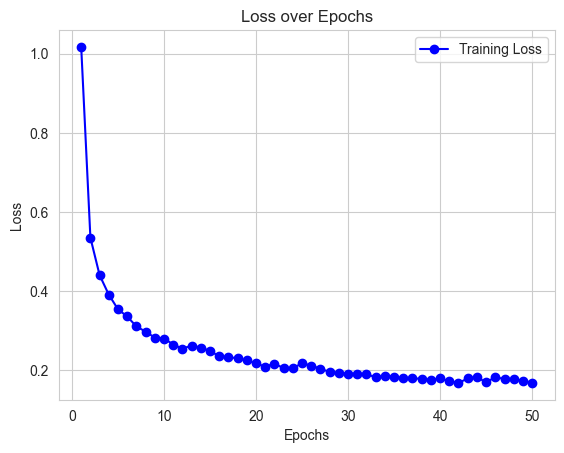

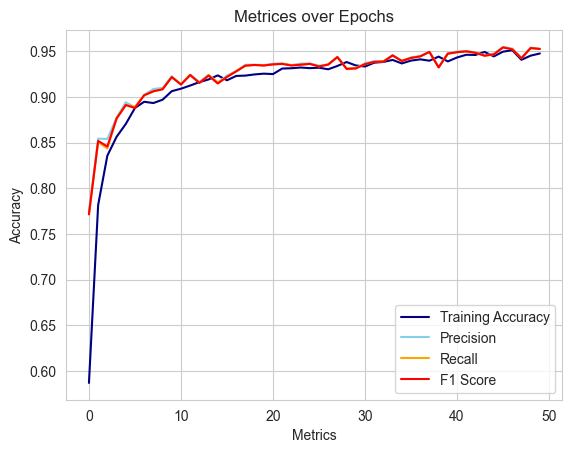

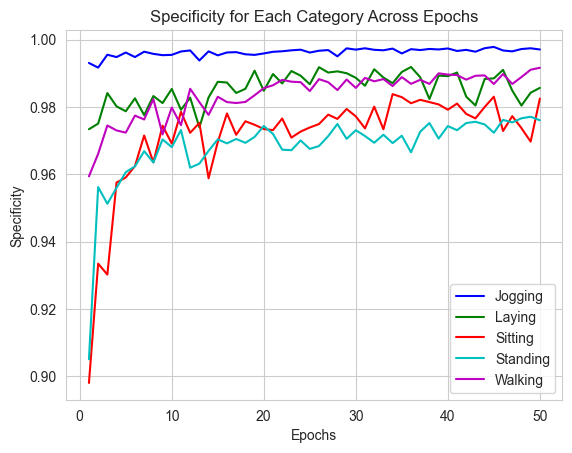

In [76]:
# Loss Per Epoch
train_loss = history_BiLstm.history['loss']
plt.plot(range(1, len(train_loss) + 1), train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy, Precision, F1 Score, Recall Graph
colors = ['navy', 'skyblue', 'orange', 'red']
train_accuracy = history.history['accuracy']
plt.plot(train_accuracy, color=colors[0], label='Training Accuracy')
plt.plot(metrics_callback_lstm.precision, color=colors[1], label='Precision')
plt.plot(metrics_callback_lstm.recall, color=colors[2], label='Recall')
plt.plot(metrics_callback_lstm.f1_score, color=colors[3], label='F1 Score')
plt.title('Metrices over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()

# Specificity Plot
colors = ['b', 'g', 'r', 'c', 'm']
activity_names = ['Jogging', 'Laying', 'Sitting', 'Standing', 'Walking']
specificity_data= np.array(metrics_callback_BiLstm.specificity)

for i in range(specificity_data.shape[1]):
    plt.plot(range(1, specificity_data.shape[0] + 1), specificity_data[:, i], label=activity_names[i], color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.title('Specificity for Each Category Across Epochs')
plt.legend()
plt.grid(True)
plt.show()